In [1]:
# import tools
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import sqlite3
import datetime as dt
import numpy as np

In [2]:
# import and sort data
cnx = sqlite3.connect('C:\\Users\\mitch\\OneDrive\\Documents\\Metis Projects\\Retrieve_MTA_Data\\mta_data.db')
df = pd.read_sql_query("SELECT * FROM mta_data", cnx)

In [3]:
# clean & add new columns
df.columns = [column.strip() for column in df.columns]
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df['DAY_OF_WEEK'] = df.DATE_TIME.dt.dayofweek

In [4]:
# clean and sort values
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_OF_WEEK
211134,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2022,21:00:00,REGULAR,0,47,2022-03-25 21:00:00,4
211133,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2022,17:00:00,REGULAR,0,45,2022-03-25 17:00:00,4
211132,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2022,13:00:00,REGULAR,0,42,2022-03-25 13:00:00,4
211131,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2022,09:00:00,REGULAR,0,42,2022-03-25 09:00:00,4
211130,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2022,05:00:00,REGULAR,0,42,2022-03-25 05:00:00,4


In [5]:
# function definitions for counting entries/exits
def get_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

def get_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["EXITS"], row["PREV_EXITS"])
        return 0
    return counter

In [6]:
# make new dataframe and groupby turnstile
ts_daily_entries = (df.groupby(["C/A", "UNIT", "SCP", "STATION", "DAY_OF_WEEK"],as_index=False).ENTRIES.first())
ts_daily_exits = (df.groupby(["C/A", "UNIT", "SCP", "STATION", "DAY_OF_WEEK"],as_index=False).EXITS.first())

# make new columns for previous entries/exits
ts_daily_entries['PREV_ENTRIES'] = ts_daily_entries.ENTRIES.shift(1)
ts_daily_exits['PREV_EXITS'] = ts_daily_exits.EXITS.shift(1)

# apply functions and set values to new column
ts_daily_entries['DAILY_ENTRIES'] = ts_daily_entries.apply(get_entries, axis=1, max_counter=1000000)
ts_daily_exits['DAILY_EXITS'] = ts_daily_exits.apply(get_exits, axis=1, max_counter=1000000)

1492116 6809918.0
158481 1747583.0
6272939 158052.0
7667895 6272560.0
12371370 7667461.0
9628206 12370673.0
525456 9627644.0
4658561 311318.0
5721633 4657770.0
3366466 6648877.0
160919 3366158.0
4309 1340751.0
119920549 792995.0
5269289 119919975.0
250303 5268911.0
5365343 249739.0
15829059 5364479.0
11580939 15828606.0
3967873 11580577.0
4977967 3967535.0
2526392 4977468.0
20228175 2525624.0
4633077 20227068.0
545655 4630808.0
4659830 1224903.0
885508145 4658725.0
199801 885508562.0
6293858 0.0
44962 6293713.0
6598378 44655.0
1573 6285317.0
7028261 134523.0
1657316 7027913.0
636262 1657069.0
13246934 36123.0
1281108 13246312.0
53859 1280640.0
9250741 53417.0
7644594 9250240.0
305405 7644524.0
4184964 305023.0
6163165 4184501.0
15655701 6162558.0
1376430 15654841.0
43150 1376374.0
10298536 43097.0
4380489 10297353.0
3064056 4379584.0
3875414 2336069.0
29248518 3874787.0
16908282 28758577.0
67857683 16906633.0
5614458 67857662.0
14640190 5880469.0
9364287 15508049.0
367914 8813121.0
276

In [7]:
# merge dataframes and sum
ts_daily_total = pd.merge(ts_daily_entries, ts_daily_exits, on = ["C/A", "UNIT", "SCP", "STATION", "DAY_OF_WEEK"])
ts_daily_total['DAILY_TRAFFIC'] = ts_daily_total.DAILY_ENTRIES + ts_daily_total.DAILY_EXITS

In [8]:
# clean dropping unnessecary columns
ts_daily_total = ts_daily_total.dropna()
dropplings = ['DAILY_EXITS', 'ENTRIES', 'PREV_ENTRIES', 'DAILY_ENTRIES', 'EXITS', 'PREV_EXITS']
ts_daily_total = ts_daily_total.drop(columns = dropplings)

In [9]:
# masks for days of the week
mon_mask = ts_daily_total.DAY_OF_WEEK == 0
tue_mask = ts_daily_total.DAY_OF_WEEK == 1
wed_mask = ts_daily_total.DAY_OF_WEEK == 2
thu_mask = ts_daily_total.DAY_OF_WEEK == 3
fri_mask = ts_daily_total.DAY_OF_WEEK == 4
sat_mask = ts_daily_total.DAY_OF_WEEK == 5
sun_mask = ts_daily_total.DAY_OF_WEEK == 6

In [10]:
ts_daily_total[mon_mask]

,C/A,UNIT,SCP,STATION,DAY_OF_WEEK,DAILY_TRAFFIC
7,A002,R051,02-00-01,59 ST,0,885442.0
14,A002,R051,02-03-00,59 ST,0,0.0
21,A002,R051,02-03-01,59 ST,0,256258.0
28,A002,R051,02-03-02,59 ST,0,0.0
35,A002,R051,02-03-03,59 ST,0,0.0
...,...,...,...,...,...,...
35151,TRAM2,R469,00-00-01,RIT-ROOSEVELT,0,29780.0
35158,TRAM2,R469,00-03-00,RIT-ROOSEVELT,0,24802.0
35165,TRAM2,R469,00-03-01,RIT-ROOSEVELT,0,368121.0
35172,TRAM2,R469,00-05-00,RIT-ROOSEVELT,0,400982.0


In [11]:
# dataframes per days of the week
mondays = ts_daily_total[mon_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()
tuesdays = ts_daily_total[tue_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()
wednesdays = ts_daily_total[wed_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()
thursdays = ts_daily_total[thu_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()
fridays = ts_daily_total[fri_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()
saturdays = ts_daily_total[sat_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()
sundays = ts_daily_total[sun_mask].groupby('STATION').DAILY_TRAFFIC.mean().reset_index()

In [12]:
# sort dataframes greatest to least
mondays = mondays.sort_values('DAILY_TRAFFIC', ascending = False)
mon_top5 = mondays.head()
tuesdays = tuesdays.sort_values('DAILY_TRAFFIC', ascending = False)
tue_top5 = tuesdays.head()
wednesdays = wednesdays.sort_values('DAILY_TRAFFIC', ascending = False)
wed_top5 = wednesdays.head()
thursdays = thursdays.sort_values('DAILY_TRAFFIC', ascending = False)
thu_top5 = thursdays.head()
fridays = fridays.sort_values('DAILY_TRAFFIC', ascending = False)
fri_top5 = fridays.head()
saturdays = saturdays.sort_values('DAILY_TRAFFIC', ascending = False)
sat_top5 = saturdays.head()
sundays = sundays.sort_values('DAILY_TRAFFIC', ascending = False)
sun_top5 = sundays.head()

In [13]:
mon_top5

,STATION,DAILY_TRAFFIC
112,88 ST,913649.333333
188,CLEVELAND ST,815033.000000
277,MARCY AV,725314.588235
292,NEPTUNE AV,712615.666667
377,ZEREGA AV,676726.000000


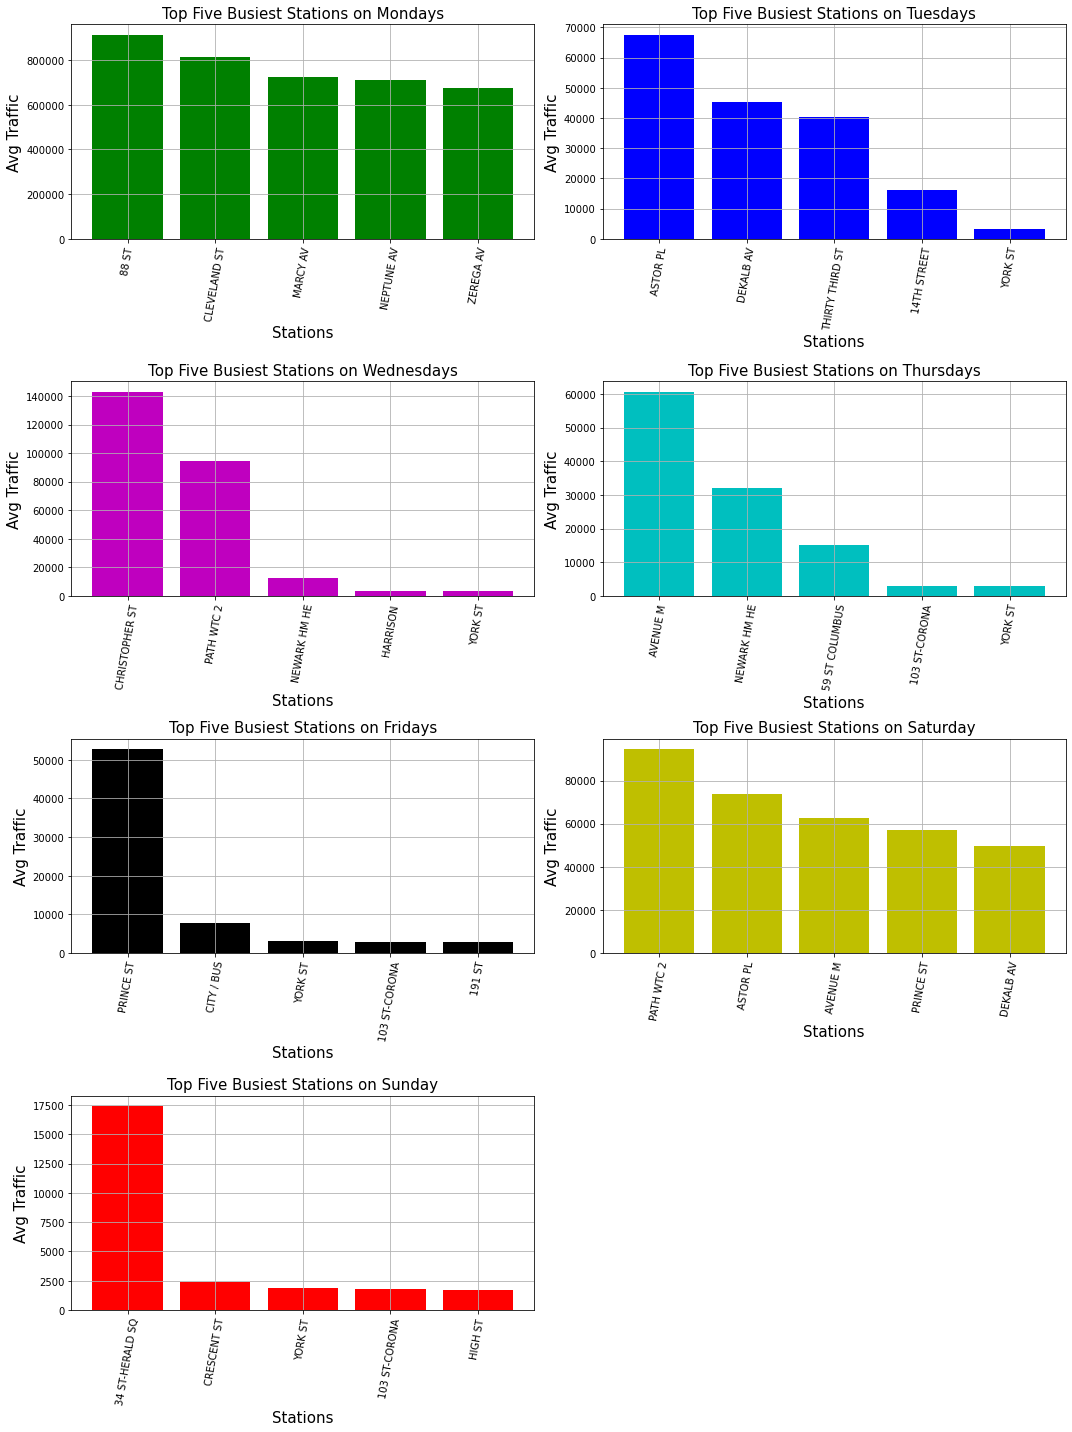

In [14]:
# plot graphs for each day of the week
plt.figure(figsize = (15, 20))

mon = plt.subplot(4, 2, 1)
plt.bar(mon_top5.STATION, mon_top5.DAILY_TRAFFIC, color = 'g')
plt.title('Top Five Busiest Stations on Mondays', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

tue = plt.subplot(4, 2, 2)
plt.bar(tue_top5.STATION, tue_top5.DAILY_TRAFFIC, color = 'b')
plt.title('Top Five Busiest Stations on Tuesdays', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

wed = plt.subplot(4, 2, 3)
plt.bar(wed_top5.STATION, wed_top5.DAILY_TRAFFIC, color = 'm')
plt.title('Top Five Busiest Stations on Wednesdays', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

thu = plt.subplot(4, 2, 4)
plt.bar(thu_top5.STATION, thu_top5.DAILY_TRAFFIC, color = 'c')
plt.title('Top Five Busiest Stations on Thursdays', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

fri = plt.subplot(4, 2, 5)
plt.bar(fri_top5.STATION, fri_top5.DAILY_TRAFFIC, color = 'k')
plt.title('Top Five Busiest Stations on Fridays', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

sat = plt.subplot(4, 2, 6)
plt.bar(sat_top5.STATION, sat_top5.DAILY_TRAFFIC, color = 'y')
plt.title('Top Five Busiest Stations on Saturday', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

sun = plt.subplot(4, 2, 7)
plt.bar(sun_top5.STATION, sun_top5.DAILY_TRAFFIC, color = 'r')
plt.title('Top Five Busiest Stations on Sunday', fontsize=15, fontweight = 20)
plt.xlabel('Stations', fontsize=15)
plt.xticks(rotation = 80)
plt.ylabel('Avg Traffic', fontsize=15)
plt.grid();

plt.tight_layout()